In [24]:
import numpy as np
from tensorflow import keras
from keras.layers import Input, Dense, Lambda
import tensorflow as tf
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from keras import backend as K
from sklearn.model_selection import train_test_split

In [25]:
# Define the desired number of samples for each class
class_samples = [2000, 3000, 2500, 1500]  # Adjust these numbers as needed

# Calculate weights based on the desired number of samples
class_weights = [num_samples / sum(class_samples) for num_samples in class_samples]


# Generate a synthetic dataset with different numbers of samples for each class
X, y = make_classification(
    n_samples=sum(class_samples),
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_classes=4,
    weights=class_weights,
    random_state=42,
)


# Create a Pandas DataFrame with the generated data
columns = ["Feature_1", "Feature_2", "Feature_3", "Feature_4"]
synthetic_df = pd.DataFrame(data=X, columns=columns)

for column in synthetic_df:
    std = np.std(synthetic_df[column])
    mean = np.mean(synthetic_df[column])
    synthetic_df[column] = synthetic_df[column]-mean
    synthetic_df[column] = synthetic_df[column]/std


synthetic_df["target"] = y

# Display the first few rows of the synthetic dataset
synthetic_array =synthetic_df.values

In [26]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [27]:
latent_dim = 10
encoder_inputs = Input(shape=(5), name="input_layer")
x1 = Dense(50, activation="relu", name="h1")(encoder_inputs)
x2 = Dense(40, activation="relu", name="h2")(x1)

n_x3 = 30

x3 = Dense(n_x3, activation="relu", name="h3")(x2)

# Split x3 into two halves
half_size = n_x3 // 2
x3_first_half = Lambda(lambda x: x[:, :half_size], name="select_z_mean")(x3)
x3_second_half = Lambda(lambda x: x[:, half_size:], name="select_z_var")(x3)

z_mean = Dense(latent_dim, name="z_mean")(x3_first_half)
z_log_var = Dense(latent_dim, name="z_log_var")(x3_second_half)
z = Sampling(name="Sampling")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

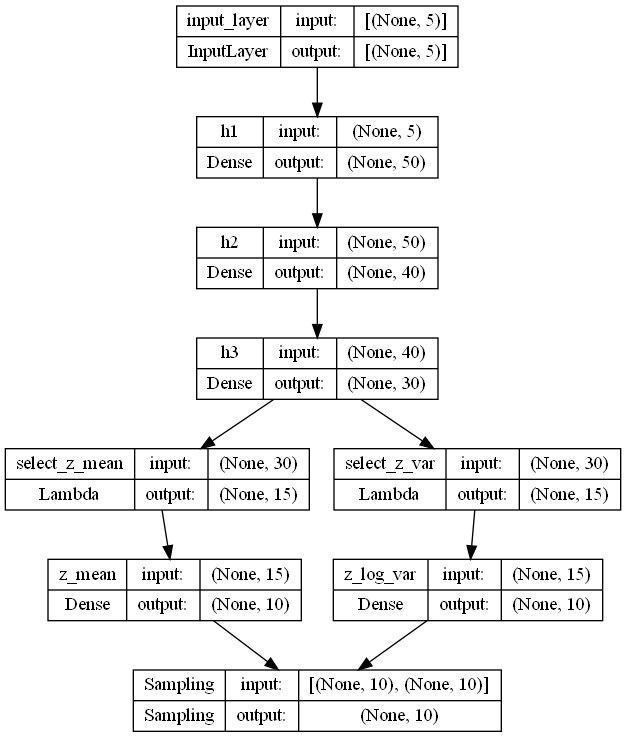

In [28]:
keras.utils.plot_model(encoder, show_shapes=True)

In [29]:
n_x6 = 50
int(n_x6 * 0.8 - 1)

39

In [30]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x4 = Dense(30, activation="relu", name="h4")(latent_inputs)
x5 = Dense(40, activation="relu", name="h5")(x4)

n_x6 = 50

x6 = Dense(n_x6, activation="relu", name="h6")(x5)

# Split x6 into two parts (80% and 20%)
cont_decoder_input = Lambda(lambda x: x[:, :int(0.8 * n_x6)], name="select_x6_cont")(x6)
class_decoder_input = Lambda(lambda x: x[:, int(0.8 * n_x6):], name="select_x6_class")(x6)

cont_decoder_outputs = Dense(4, name="cont_decoder_output")(cont_decoder_input)
class_decoder_output = Dense(4, activation="softmax", name="classification_output")(class_decoder_input)

decoder = keras.Model(latent_inputs, [cont_decoder_outputs, class_decoder_output], name="decoder")
decoder.summary()


Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 h4 (Dense)                     (None, 30)           330         ['input_2[0][0]']                
                                                                                                  
 h5 (Dense)                     (None, 40)           1240        ['h4[0][0]']                     
                                                                                                  
 h6 (Dense)                     (None, 50)           2050        ['h5[0][0]']                     
                                                                                            

 cont_decoder_output (Dense)    (None, 4)            164         ['select_x6_cont[0][0]']         
                                                                                                  
 classification_output (Dense)  (None, 4)            44          ['select_x6_class[0][0]']        
                                                                                                  
Total params: 3,828
Trainable params: 3,828
Non-trainable params: 0
__________________________________________________________________________________________________


In [31]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reconstruction_loss_class_tracker = keras.metrics.Mean(
            name="reconstruction_loss_class"
        )

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.reconstruction_loss_class_tracker,
            keras.metrics.SparseCategoricalCrossentropy(
                name="sparse_categorical_crossentropy"
            ),
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction_cont, reconstruction_class = self.decoder(z)

            data_cont = data[
                :, :4
            ]  # Assuming the first 4 columns are for continuous variables
            data_class = data[:, 4:]  # Assuming the last column is for classification

            # Reconstruction loss for continuous outputs
            reconstruction_loss_cont = keras.losses.mean_squared_error(
                data_cont, reconstruction_cont
            )

            # Reconstruction loss for classification output
            reconstruction_loss_class = keras.losses.sparse_categorical_crossentropy(
                data_class, reconstruction_class
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)

            # Combine losses
            total_loss = (
                0.8*reconstruction_loss_cont + 0.2*reconstruction_loss_class + kl_loss
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_cont)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_class_tracker.update_state(reconstruction_loss_class)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_cont": self.reconstruction_loss_tracker.result(),
            "reconstruction_loss_class": self.reconstruction_loss_class_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "sparse_categorical_crossentropy": self.reconstruction_loss_class_tracker.result(), 
        }

In [32]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [33]:


# Specify the test_size and validation_size according to your needs
test_size = 0.2  # 80% training, 20% test
validation_size = 0.1  # 80% training, 10% validation

# Split into training and temporary data
train_data, temp_data = train_test_split(
    synthetic_array, test_size=test_size + validation_size, random_state=42
)

# Split the temporary data into test and validation
test_data, validation_data = train_test_split(
    temp_data,
    test_size=validation_size / (test_size + validation_size),
    random_state=42,
)


# # Convert NumPy arrays to tf.data.Dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
# validation_dataset = tf.data.Dataset.from_tensor_slices(
#     (validation_data, validation_data)
# )
# test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_data))

In [34]:
from keras.callbacks import EarlyStopping

vae.fit(
    synthetic_array,
    epochs=70,
    batch_size=16,
    callbacks=[EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)],
)

Epoch 1/70
563/563 [==============================] - 4s 5ms/step - loss: 1.0458 - reconstruction_loss_cont: 0.9167 - reconstruction_loss_class: 1.3199 - kl_loss: 0.0908 - sparse_categorical_crossentropy: 1.3199
Epoch 2/70
563/563 [==============================] - 2s 4ms/step - loss: 0.8003 - reconstruction_loss_cont: 0.4248 - reconstruction_loss_class: 1.0880 - kl_loss: 0.2497 - sparse_categorical_crossentropy: 1.0880
Epoch 3/70
563/563 [==============================] - 3s 4ms/step - loss: 0.7152 - reconstruction_loss_cont: 0.3050 - reconstruction_loss_class: 0.9599 - kl_loss: 0.2783 - sparse_categorical_crossentropy: 0.9599
Epoch 4/70
563/563 [==============================] - 2s 4ms/step - loss: 0.6751 - reconstruction_loss_cont: 0.2640 - reconstruction_loss_class: 0.8334 - kl_loss: 0.2958 - sparse_categorical_crossentropy: 0.8334
Epoch 5/70
563/563 [==============================] - 2s 4ms/step - loss: 0.6485 - reconstruction_loss_cont: 0.2478 - reconstruction_loss_class: 0.7022 

In [45]:
latent_vectors = np.random.normal(size=(9000, latent_dim))

# Use the decoder to generate data
generated_data_cont, generated_data_class = vae.decoder.predict(latent_vectors)

282/282 [==============================] - 0s 1ms/step


In [46]:
generated_data_class_transformed = np.argmax(generated_data_class, axis=1)

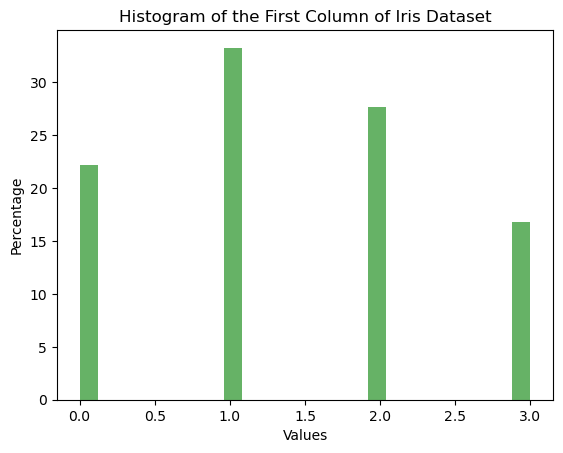

In [47]:
# Assuming iris_array is the NumPy array you obtained from the Pandas DataFrame
first_column = synthetic_array[:, 4]

# Calculate the percentage
total_points = len(first_column)
percentage = (first_column / total_points) * 100

# Plot histogram with weights
plt.hist(
    first_column,
    bins=25,
    color="g",
    alpha=0.6,
    weights=np.ones_like(first_column) / total_points * 100,
)
plt.title("Histogram of the First Column of Iris Dataset")
plt.xlabel("Values")
plt.ylabel("Percentage")
plt.show()

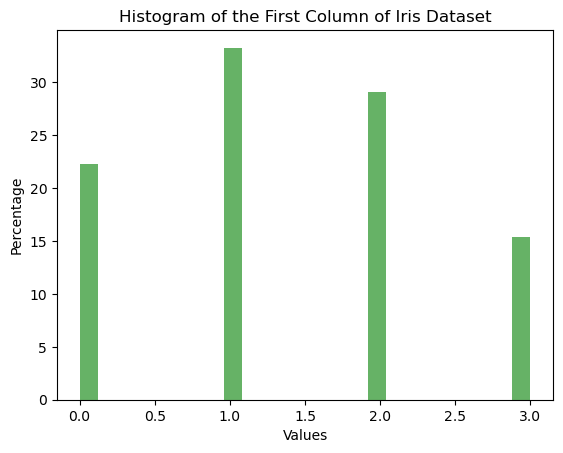

In [48]:
# Assuming iris_array is the NumPy array you obtained from the Pandas DataFrame
first_column = generated_data_class_transformed

# Calculate the percentage
total_points = len(first_column)
percentage = (first_column / total_points) * 100

# Plot histogram with weights
plt.hist(
    first_column,
    bins=25,
    color="g",
    alpha=0.6,
    weights=np.ones_like(first_column) / total_points * 100,
)
plt.title("Histogram of the First Column of Iris Dataset")
plt.xlabel("Values")
plt.ylabel("Percentage")
plt.show()

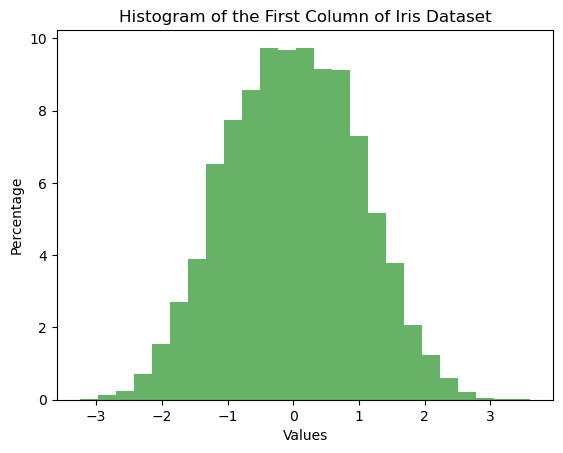

In [49]:
# Assuming iris_array is the NumPy array you obtained from the Pandas DataFrame
first_column = synthetic_array[:, 1]

# Calculate the percentage
total_points = len(first_column)
percentage = (first_column / total_points) * 100

# Plot histogram with weights
plt.hist(
    first_column,
    bins=25,
    color="g",
    alpha=0.6,
    weights=np.ones_like(first_column) / total_points * 100,
)
plt.title("Histogram of the First Column of Iris Dataset")
plt.xlabel("Values")
plt.ylabel("Percentage")
plt.show()

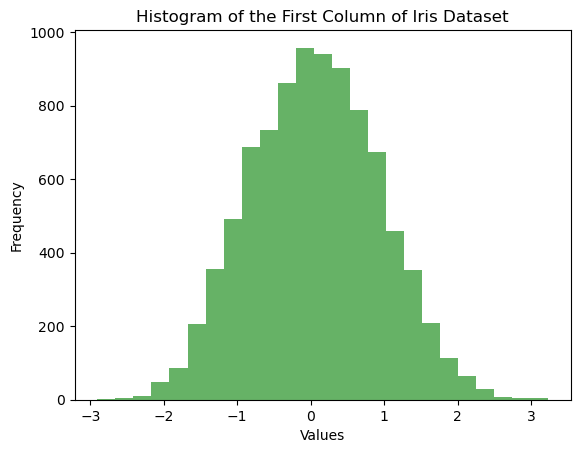

In [50]:
# Assuming iris_array is the NumPy array you obtained from the Pandas DataFrame
first_column = generated_data_cont[:, 1]

# Plot histogram
plt.hist(first_column, bins=25, color="g", alpha=0.6)
plt.title("Histogram of the First Column of Iris Dataset")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

In [52]:
synthetic_array[:, 1]

array([ 1.92185791, -1.1803525 , -0.65872548, ..., -0.76488573,
        0.8426321 ,  1.43199527])

In [53]:
generated_data_cont[:, 1]

array([ 1.166388  , -0.9083656 ,  1.0234121 , ...,  0.61383605,
       -0.07954051,  0.3516659 ], dtype=float32)

In [54]:
from scipy.stats import entropy



entropy(
    synthetic_array[:, 1], qk=generated_data_cont[:, 1], base=2
)  # base=2 for logarithm base 2


inf

In [64]:
def kl_divergence_histogram(p, q, bins=10):
    hist_p, bin_edges = np.histogram(p, bins=bins, density=True)
    hist_q, _ = np.histogram(q, bins=bin_edges, density=True)

    #kl_div = np.sum(hist_p * np.log(hist_p / (hist_q + 1e-10)))

    return  hist_p, hist_q

In [55]:
def kl_divergence_histogram(p, q, bins=10):
    hist_p, bin_edges = np.histogram(p, bins=bins, density=True)
    hist_q, _ = np.histogram(q, bins=bin_edges, density=True)

    kl_div = np.sum(hist_p * np.log(hist_p / (hist_q + 1e-10)))

    return kl_div, hist_p, hist_q


# Example usage
array_p = np.array([1.166388, -0.9083656, 1.0234121])
array_q = np.array([0.61383605, -0.07954051, 0.3516659])

result = kl_divergence_histogram(array_p, array_q, bins=10)
print(f"KL Divergence: {result}")

KL Divergence: nan


C:\Users\Max_G\AppData\Local\Temp\ipykernel_24376\2172624307.py:5: RuntimeWarning: divide by zero encountered in log
  kl_div = np.sum(hist_p * np.log(hist_p / (hist_q + 1e-10)))
C:\Users\Max_G\AppData\Local\Temp\ipykernel_24376\2172624307.py:5: RuntimeWarning: invalid value encountered in multiply
  kl_div = np.sum(hist_p * np.log(hist_p / (hist_q + 1e-10)))
